# Qwen3 Tuning
for ARC AGI 2

Updates 24 July 2025:
- Now supports calculation of metrics BUT requires validation data have code. This will be updated later to just pass grids for validation.

Updates 23 July 2025:
- Back to constant scheduler for one epoch. Note that SOAR use 3 epochs with cosine scheduler.

Updates 22 July 2025:
- Increased lora r to 256
- Added training on completions only
- Moved to cosine rather than constant scheduler. Moved from 1 to 2 epochs. Note that SOAR use 3 epochs with cosine scheduler.

### Installation

In [1]:
%%capture
import os
!pip install uv -qU
!uv pip install unsloth matplotlib tensorboard -qU --system
!export HF_HUB_ENABLE_HF_TRANSFER=1

In [2]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [3]:
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006 --bind_all

### Unsloth

In [4]:
from unsloth import FastLanguageModel
import torch, os

# model_slug = "Qwen/Qwen3-4B"
model_slug = "julien31/Soar-qwen-7b"
# model_slug = "Qwen/Qwen2.5-Coder-7B-Instruct"
# model_slug = "Qwen/Qwen3-30B-A3B"

model_max_length = 32000

# Training AND validation batch size (incl. for autoregressive train/test example metrics calculations)
batch_size_global=2 # use 2 for 7/8B, use 8 for 4B

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_slug,
    max_seq_length = model_max_length,   # Context length - can be longer, but uses more memory
    load_in_4bit = False,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    cache_dir = '',
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.8: Fast Qwen2 patching. Transformers: 4.53.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.209 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# print(model)

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128. could consider 128.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",
                     ],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.7.8 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


<a name="Data"></a>
### Data Prep

In [7]:
from pathlib import Path
import json
from typing import Optional
from datasets import load_dataset, DatasetDict

# ---------------------------------------------------------------------
# Config (examples)
# ---------------------------------------------------------------------

# Set max_rows flag to limit train size. None for all
max_rows = None

# CASE 1: single slug with both splits
train_slug = "Trelis/synth_arc-agi-1_all_training_20250724_131808"
val_slug = None

# # CASE 2: two different slugs
# train_slug = "Trelis/synth_arc-agi-1_shortest_training_10_20250724_091954"
# val_slug   = "Trelis/synth_arc-agi-1_shortest_training_10_20250724_091954"

include_reasoning = False  # See note in original code

SYSTEM_PROMPT = "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."

INITIAL_TURN_PROMPT = """You are solving an ARC (Abstraction and Reasoning Corpus) task. 
I will show you training examples with input and output grids, plus a test input grid. Your task is to:

1. **Analyze the training examples** to discover patterns that map input grids to output grids
2. **Write a Python program** that implements your best understanding of the transformation  
3. **DO NOT predict or generate the test output** - your job is only to write the transformation program
4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis
5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.
{grid_size_info}
The test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding.

{task_str}

Analyze the patterns in the training examples and write a Python function that performs this transformation.

**Approach Guidelines:**
- Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc.
- Even if you can't solve all training examples perfectly, implement what patterns you do observe
- A partial solution that captures some aspects is better than returning the input unchanged
- If the pattern is unclear, make your best educated guess based on what you can see

Requirements:
- The function takes a 2D list (grid) where grid[row][col] gives the value at that position
- Values are integers from 0-9
- Return a new grid (2D list) with the transformation applied
- You can use numpy if needed - just add 'import numpy as np' at the start of your function
- Aim to handle the training examples as well as possible, even if not perfectly
- Your function should attempt some meaningful transformation based on the patterns you observe

You MUST end your response with the following exact format:

Final answer:
```python
def transform(grid):
    # Your transformation logic here (implement your best understanding)
    return transformed_grid
```"""

def format_grid(grid):
    """Format a grid exactly like run_arc_tasks.py _format_grid"""
    lines = []
    for row in grid:
        if len(row) == 0:
            lines.append('[EMPTY_ROW]')
        else:
            lines.append(' '.join(str(cell) for cell in row))
    return '\n'.join(lines)

def generate_grid_size_info(train_outputs):
    """Generate grid size info exactly like run_arc_tasks.py"""
    if train_outputs and len(train_outputs) > 0 and train_outputs[0]:
        output_grid = train_outputs[0]
        output_height = len(output_grid)
        output_width = len(output_grid[0]) if output_grid else 0
        return f"\n**IMPORTANT: Your transformation must always produce a {output_height}×{output_width} output grid.**\n"
    else:
        return ""

def format_task_for_prompt(train_input, train_output, test_input):
    """Format task exactly like run_arc_tasks.py format_task_for_prompt"""
    lines = []
    lines.append("Training Examples:")
    for i, (inp, out) in enumerate(zip(train_input, train_output)):
        lines.append(f"\nExample {i+1}:")
        lines.append("Input:")
        lines.append(format_grid(inp))
        lines.append("Output:")
        lines.append(format_grid(out))
    lines.append("\nTest Input:")
    lines.append(format_grid(test_input))
    return '\n'.join(lines)

def hf_dataset_to_chat_dataset(dataset_slug: str, split: str = "train"):
    """
    Convert a HF split into the chat/prompt format.
    """
    ds = load_dataset(dataset_slug, split=split, keep_in_memory=True)

    def create_chat_messages(example):
        grid_size_info = generate_grid_size_info(example["train_output"])
        task_str = format_task_for_prompt(example["train_input"],
                                          example["train_output"],
                                          example["test_input"])

        user_content = INITIAL_TURN_PROMPT.format(
            grid_size_info=grid_size_info,
            task_str=task_str
        )

        assistant_content = ""
        if include_reasoning and example.get("reasoning", "").strip():
            assistant_content += f"<think>{example['reasoning'].strip()}</think>"
        assistant_content += f"Final answer:\n```python\n{example['code']}\n```"

        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": user_content},
            {"role": "assistant", "content": assistant_content},
        ]

        prompt_messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": user_content},
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
        )

        prompt_text = tokenizer.apply_chat_template(
            prompt_messages,
            tokenize=False,
            add_generation_prompt=True,
        )

        if not include_reasoning:
            prompt_text += "<think>\n\n</think>\n\n"

        return {
            "messages": messages,
            "text": text,
            "prompt": prompt_text,
            "train_input": example["train_input"],
            "train_output": example["train_output"],
            "test_input": example["test_input"],
            "test_output": example["test_output"],
            "reasoning": example.get("reasoning", ""),
            "code": example["code"],
            "task_id": example.get("task_id", ""),
        }

    ds = ds.map(create_chat_messages, desc=f"build chat + prompt fields ({split})")
    return ds

def build_dataset(train_slug: str,
                  val_slug: Optional[str] = None,
                  train_split: str = "train",
                  val_split: str = "validation") -> DatasetDict:
    """
    Build a DatasetDict with 'train' and 'validation' keys.
    - If val_slug is None, both splits are loaded from train_slug.
    - Otherwise, load train_split from train_slug and val_split from val_slug.
    """
    
    # Load and filter
    train_ds = hf_dataset_to_chat_dataset(train_slug, split=train_split)
    if max_rows:
        train_ds = train_ds.select(range(min(len(train_ds), max_rows)))

    # Validation logic
    if val_slug is None:
        # Use the same slug, but a different split
        try:
            val_ds = hf_dataset_to_chat_dataset(train_slug, split=val_split)
        except Exception as e:
            raise ValueError(
                f"Could not load split '{val_split}' from '{train_slug}'. "
                f"Pass an explicit val_slug or choose a valid split.\nOriginal error: {e}"
            )
    else:
        val_ds = hf_dataset_to_chat_dataset(val_slug, split=val_split)

    if max_rows:
        val_ds = val_ds.select(range(min(len(train_ds), max_rows)))

    return DatasetDict(train=train_ds, validation=val_ds)

# ---------------------------------------------------------------------
# Build the dataset
# ---------------------------------------------------------------------
data = build_dataset(train_slug, val_slug)  # val_slug may be None


build chat + prompt fields (train):   0%|          | 0/751 [00:00<?, ? examples/s]

build chat + prompt fields (validation):   0%|          | 0/32 [00:00<?, ? examples/s]

In [8]:
# print(data["train"][0])
print(data["train"][0]['prompt'])

<|im_start|>system
You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code.<|im_end|>
<|im_start|>user
You are solving an ARC (Abstraction and Reasoning Corpus) task. 
I will show you training examples with input and output grids, plus a test input grid. Your task is to:

1. **Analyze the training examples** to discover patterns that map input grids to output grids
2. **Write a Python program** that implements your best understanding of the transformation  
3. **DO NOT predict or generate the test output** - your job is only to write the transformation program
4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis
5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.

**IMPORTANT: Your transformation must always produce a 3×3 output grid.**

The test input is shown for context so you understand what type of grid your program will eventually process. F

Let's see the structure of both datasets:

In [9]:
import numpy as np
from statistics import median

def length_stats(dataset, name=""):
    """
    Return min / median / max tokenised length for a 🤗 Dataset split that has a
    single 'text' column. Uses the same tokenizer already in memory.
    """
    # Tokenise in batches → list of list[int] → list[int] lengths
    lengths = dataset.map(
        lambda batch: {
            "len": [len(ids) for ids in tokenizer(batch["text"],
                                                  add_special_tokens=False
                                                 )["input_ids"]]
        },
        batched=True,
        remove_columns=dataset.column_names,   # drop 'text'
        keep_in_memory=True,
    )["len"]

    print(f"{name:>11}:  min={min(lengths):>4}  "
          f"median={int(median(lengths)):>4}  max={max(lengths):>4}")

# ── run for both splits ────────────────────────────────────────────────────────
length_stats(data["train"],       "train")
length_stats(data["validation"],  "validation")


Map:   0%|          | 0/751 [00:00<?, ? examples/s]

      train:  min= 746  median=3183  max=17931


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

 validation:  min= 840  median=4317  max=10110


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [10]:
from datetime import datetime
import re

# Extract date and time using regex
print("Extract training set date and time as dataset identifiers")
match = re.search(r'(\d{8}_\d{6})$', train_slug)
if match:
    timestamp = match.group(1)
    date_str = timestamp[:8]
    time_str = timestamp[9:]

    print(f"Date: {date_str} (YYYYMMDD)")
    print(f"Time: {time_str} (HHMMSS)")
else:
    print("No timestamp found.")

run_name = f"{model_slug.split('/')[-1]}-ds{date_str}_{time_str}-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
print(f"Run name will be {run_name}")

Extract training set date and time as dataset identifiers
Date: 20250724 (YYYYMMDD)
Time: 131808 (HHMMSS)
Run name will be Soar-qwen-7b-ds20250724_131808-20250725-113741


In [11]:
import re, copy, traceback, numpy as np, torch, signal
from types import FunctionType
from transformers.trainer_utils import EvalPrediction

# ---- regex
_FINAL_ANSWER_RE = re.compile(r"Final answer:\s*```python\s*\n(.*?)\n```", re.I|re.S)
_LAST_PYBLOCK_RE = re.compile(r"```python\s*\n(.*?)\n```", re.I|re.S)
def extract_python_code(txt):
    m = _FINAL_ANSWER_RE.search(txt)
    if m: return m.group(1).strip()
    blocks = _LAST_PYBLOCK_RE.findall(txt)
    return blocks[-1].strip() if blocks else None

def grid_to_str(g): return "\n".join(" ".join(map(str, r)) for r in g)
def grids_equal(a,b): return a == b

# ---- tiny unix timeout (use multiprocessing on Windows)
class _Timeout(Exception): pass
def _handler(signum, frame): raise _Timeout()
def run_with_timeout(fn, *args, seconds=1.0, **kwargs):
    old = signal.signal(signal.SIGALRM, _handler)
    signal.setitimer(signal.ITIMER_REAL, seconds)
    try: return fn(*args, **kwargs)
    finally:
        signal.setitimer(signal.ITIMER_REAL, 0)
        signal.signal(signal.SIGALRM, old)

def strip_prefix(full_ids: torch.Tensor, prompt_ids: torch.Tensor) -> torch.Tensor:
    plen = prompt_ids.size(0)
    return full_ids[plen:] if plen <= full_ids.size(0) and torch.equal(full_ids[:plen], prompt_ids) else full_ids


In [12]:
def generate_eval_core(model, tokenizer, dataset, *,
                       gen_kwargs,
                       text_field="prompt",
                       max_items=None,
                       print_n=3,
                       print_all_grids=True,
                       exec_timeout=0.5,
                       gen_batch_size=8,
                       pad_last_to_batch=True,
                       debug_every=10):  # DEBUG: print heartbeat every N examples
    import torch, copy, traceback, numpy as np, signal, time, sys
    from types import FunctionType

    from unsloth import FastLanguageModel

    # ──▶ enter fast‑inference mode once, before any .generate()
    FastLanguageModel.for_inference(model)

    # ---------- timeout helpers ----------
    class _Timeout(Exception): pass
    def _h(_, __): raise _Timeout()
    def run_with_timeout_local(fn, *args, seconds=1.0, **kwargs):
        old = signal.signal(signal.SIGALRM, _h)
        signal.setitimer(signal.ITIMER_REAL, seconds)
        try:    return fn(*args, **kwargs)
        finally:
            signal.setitimer(signal.ITIMER_REAL, 0)
            signal.signal(signal.SIGALRM, old)

    # ---------- prefix strip ----------
    def strip_prefix(full_ids: torch.Tensor, prompt_ids: torch.Tensor) -> torch.Tensor:
        plen = prompt_ids.size(0)
        return full_ids[plen:] if plen <= full_ids.size(0) and torch.equal(full_ids[:plen], prompt_ids) else full_ids

    device = model.device
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id
    tokenizer.padding_side = "right"

    model.eval()
    N = len(dataset) if max_items is None else min(max_items, len(dataset))
    tr_scores, te_scores = [], []

    total_batches = (N + gen_batch_size - 1) // gen_batch_size

    for b_i, start in enumerate(range(0, N, gen_batch_size)):
        end = min(start + gen_batch_size, N)
        chunk = [dataset[i] for i in range(start, end)]
        mask_keep = [True] * len(chunk)

        if pad_last_to_batch and len(chunk) < gen_batch_size:
            pad_needed = gen_batch_size - len(chunk)
            chunk += [chunk[-1]] * pad_needed
            mask_keep += [False] * pad_needed

        prompts = [ex[text_field] for ex in chunk]

        # DEBUG: timing
        t0 = time.perf_counter()
        inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(device)
        t_tok = time.perf_counter()

        with torch.no_grad():
            gen_ids = model.generate(**inputs, **gen_kwargs)
        # optional cuda sync for accurate timing
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t_gen = time.perf_counter()

        pad_id = tokenizer.pad_token_id
        prompt_lens = (inputs["input_ids"] != pad_id).sum(dim=1)

        # DEBUG batch heartbeat
        print(f"[GEN] batch {b_i+1}/{total_batches} | size={len(chunk)} (keep {sum(mask_keep)}) "
              f"| tok {1000*(t_tok-t0):.1f}ms gen {1000*(t_gen-t_tok):.1f}ms", flush=True)

        for b_idx, keep in enumerate(mask_keep):
            if not keep:
                continue
            global_idx = start + b_idx

            full_ids   = gen_ids[b_idx]
            prompt_ids = inputs["input_ids"][b_idx][:prompt_lens[b_idx]]
            new_ids    = strip_prefix(full_ids, prompt_ids)
            pred_text  = tokenizer.decode(new_ids, skip_special_tokens=True) if new_ids.numel() else ""

            code = extract_python_code(pred_text)

            tr_in, tr_out = chunk[b_idx]["train_input"], chunk[b_idx]["train_output"]
            te_in, te_out = chunk[b_idx]["test_input"],  chunk[b_idx]["test_output"]

            tr_preds, te_preds = [], []
            tr_hits = te_hits = 0
            exec_err = None
            rt_train_err, rt_test_err = [], []

            transform = None
            if code:
                try:
                    import numpy as np
                    # Seed the exec environment. Use the SAME dict for globals & locals.
                    env = {"__builtins__": __builtins__, "np": np}
                    exec(code, env, env)
                    transform = env.get("transform")
                    if not isinstance(transform, FunctionType):
                        exec_err = "transform() missing"
                    else:
                        # Safety net: if the model forgot `import numpy as np`
                        transform.__globals__.setdefault("np", np)
                except Exception:
                    exec_err = traceback.format_exc()
            else:
                exec_err = "no code extracted"

            def _safe_apply(fn, grid):
                try:
                    return run_with_timeout_local(fn, copy.deepcopy(grid), seconds=exec_timeout), None
                except _Timeout:
                    return None, "Timeout"
                except Exception:
                    return None, traceback.format_exc()

            t_exec0 = time.perf_counter()
            if transform:
                for g in tr_in:
                    out, err = _safe_apply(transform, g)
                    tr_preds.append(out);  rt_train_err += [err] if err else []
                for g in te_in:
                    out, err = _safe_apply(transform, g)
                    te_preds.append(out);  rt_test_err  += [err] if err else []
            else:
                tr_preds = [None]*len(tr_in)
                te_preds = [None]*len(te_in)
            t_exec1 = time.perf_counter()

            for p,g in zip(tr_preds,tr_out): tr_hits += int(p is not None and grids_equal(p,g))
            for p,g in zip(te_preds,te_out): te_hits += int(p is not None and grids_equal(p,g))

            tr_s = tr_hits/len(tr_in); te_s = te_hits/len(te_in)
            tr_scores.append(tr_s);    te_scores.append(te_s)

            # DEBUG: per-example timing heartbeat
            if (global_idx % debug_every) == 0 and global_idx >= print_n:
                print(f"[GEN] ex {global_idx}/{N} | exec {1000*(t_exec1-t_exec0):.1f}ms "
                      f"| scores T:{tr_s:.0%} E:{te_s:.0%}", flush=True)

            # Full debug block
            if global_idx < print_n:
                print("\n" + "="*90)
                print(f"Example {global_idx}")
                if exec_err: print("[EXEC ERROR]\n" + exec_err)
                for e in rt_train_err: print("-- train grid error --\n" + e)
                for e in rt_test_err:  print("-- test  grid error --\n"  + e)
                # print("\n[Raw Response]\n" + (pred_text or "<none>"))
                print("\n[Extracted code]\n" + (code or "<none>"))
                print(f"\n[Scores] train {tr_hits}/{len(tr_in)} ({tr_s:.0%}) | test {te_hits}/{len(te_in)} ({te_s:.0%})")

                if print_all_grids:
                    for i,(gt,pd) in enumerate(zip(tr_out,tr_preds)):
                        corr = pd is not None and grids_equal(pd, gt)
                        print(f"\n-- Train {i} | correct={corr}")
                        print("GT:\n"+grid_to_str(gt)); print("\nPred:\n"+(grid_to_str(pd) if pd else "<none>"))
                    for i,(gt,pd) in enumerate(zip(te_out,te_preds)):
                        corr = pd is not None and grids_equal(pd, gt)
                        print(f"\n-- Test {i} | correct={corr}")
                        print("GT:\n"+grid_to_str(gt)); print("\nPred:\n"+(grid_to_str(pd) if pd else "<none>"))

        # 🧹 Batch cleanup
        del inputs, gen_ids, prompt_lens, chunk, prompts, mask_keep
        del tr_preds, te_preds, rt_train_err, rt_test_err
        torch.cuda.empty_cache()
        gc.collect()

    tr_mean = float(np.mean(tr_scores)) if tr_scores else 0.0
    te_mean = float(np.mean(te_scores))  if te_scores else 0.0
    overall = 0.5 * (tr_mean + te_mean)

    print("\n" + "#"*90)
    print(f"GEN BATCH SCORES  train:{tr_mean:.1%}  test:{te_mean:.1%}  overall:{overall:.1%}")
    print("#"*90 + "\n")

    # 🧹 Final cleanup
    torch.cuda.empty_cache()
    gc.collect()

    # ──▶ exit back to training mode just before returning
    FastLanguageModel.for_training(model)

    return {"gen_train_score": tr_mean, "gen_test_score": te_mean, "gen_overall": overall}


In [13]:
stop_ids = [tokenizer.eos_token_id]

gen_kwargs = dict(
    # max_new_tokens=model_max_length / 2,
    max_new_tokens=1000, # just enough for code to be produced.
    num_beams=1,
    do_sample=False,
    eos_token_id=stop_ids,
)

In [14]:
# --- after generate_eval_core() ---
def run_gen_metrics(model, tokenizer, ds, gen_kwargs):
    return generate_eval_core(
        model, tokenizer, ds,
        gen_kwargs=gen_kwargs,
        text_field="prompt",
        max_items=None,
        print_n=8,
        print_all_grids=True,
        exec_timeout=0.5,
        gen_batch_size=batch_size_global,        # if you want batching
        pad_last_to_batch=True,
    )

In [15]:
from trl import SFTTrainer, SFTConfig

# ✅ Do this at the top of the file or notebook
import gc
import torch

class GenSFTTrainer(SFTTrainer):
    def __init__(self, *args, gen_kwargs=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.gen_kwargs = gen_kwargs or {}

    # # keep your custom prediction_step ONLY if you still want loss during eval
    # def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
    #     loss = None
    #     if "labels" in inputs:
    #         with torch.no_grad():
    #             outputs = model(**inputs)
    #             loss = outputs.loss.detach()
    #     with torch.no_grad():
    #         gen = model.generate(
    #             input_ids=inputs["input_ids"],
    #             attention_mask=inputs.get("attention_mask"),
    #             **self.gen_kwargs
    #         )
    #     return (loss, gen, None)

    # <<< THIS is the important bit >>>
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix: str = "eval"):
        base = super().evaluate(eval_dataset=eval_dataset,
                                ignore_keys=ignore_keys,
                                metric_key_prefix=metric_key_prefix)
    
        raw_ds = eval_dataset if eval_dataset is not None else self.eval_dataset
        gen_metrics = run_gen_metrics(self.model, self.tokenizer, raw_ds, self.gen_kwargs)
    
        # ✅ Do this first, while gen_metrics still exists
        gen_metrics = {f"{metric_key_prefix}_{k}": v for k, v in gen_metrics.items()}
        metrics = {**base, **gen_metrics}
        self.log(metrics)
    
        # ✅ Then clean up
        import gc
        del raw_ds
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
    
        return metrics


In [16]:
# Update the trainer configuration to use the fixed custom metrics
from trl import SFTTrainer, SFTConfig

# make sure the attr exists so Unsloth can safely delete it
setattr(model, "_flag_for_generation", True)

trainer = GenSFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    args=SFTConfig(
        dataset_text_field="text",
        per_device_train_batch_size=batch_size_global,
        per_device_eval_batch_size=batch_size_global,
        gradient_accumulation_steps=int(32 / batch_size_global),
        warmup_steps=5,
        eval_steps=0.2,
        do_eval=True,
        eval_strategy="steps",
        num_train_epochs=1,
        # max_steps=3,
        learning_rate=1e-4,
        logging_steps=0.05,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="constant",
        seed=3407,
        report_to="tensorboard",
        logging_dir=f"./logs/{run_name}",
        prediction_loss_only=False,   # we return preds
        remove_unused_columns=True,
    ),
    gen_kwargs=gen_kwargs,
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/751 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/32 [00:00<?, ? examples/s]

In [17]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H100 80GB HBM3. Max memory = 79.209 GB.
15.674 GB of memory reserved.


In [18]:
# We should consider training on completions only!!! which means the response part for the xentropy.

In [19]:
from unsloth.chat_templates import train_on_responses_only # or run the code above if not using unsloth

TEMPLATES = {
    "llama": (
        "<|start_header_id|>user<|end_header_id|>\n\n",
        "<|start_header_id|>assistant<|end_header_id|>\n\n",
    ),
    "gemma": (
        "<start_of_turn>user\n",
        "<start_of_turn>model\n",
    ),
    "qwen-coder": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "qwen": (
        "<|im_start|>user\n",
        "<|im_start|>assistant\n<think>\n\n</think>\n\n", # this is actually how you properly allow the model to keep reasoning!
    ),
    "mistral": (
        "[INST]",
        "[/INST]",
    )
}

# instruction_tag, response_tag = TEMPLATES["qwen-coder"]   # ← change if needed and comment out below

model_slug_lower = model_slug.lower()

if "qwen" in model_slug_lower:
    if "coder" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    elif "soar-qwen" in model_slug_lower:
        instruction_tag, response_tag = TEMPLATES["qwen-coder"]
    else:
        instruction_tag, response_tag = TEMPLATES["qwen"]
else:
    raise ValueError(f"Unsupported model slug for Qwen template: {model_slug}")

# TO SUPPORT REASONING, WE NEED TO DYNAMICALLY APPLY THE RIGHT MASKING, NOT YET IMPLEMENTED
# masks everything between the instruction_part and response_part
trainer = train_on_responses_only(
    trainer,
    instruction_part = instruction_tag,
    response_part = response_tag,
    # force_match=False # comment out to set true for a cleaner masking
)

Map (num_proc=224):   0%|          | 0/751 [00:00<?, ? examples/s]

num_proc must be <= 32. Reducing num_proc to 32 for dataset of size 32.


Map (num_proc=32):   0%|          | 0/32 [00:00<?, ? examples/s]

In [20]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

"<|im_start|>system\nYou are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code.<|im_end|>\n<|im_start|>user\nYou are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 3×3 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will eventu

In [21]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Final answer:\n```python\ndef transform(grid):\n    transformed_grid = [[0 for _ in range(3)] for _ in range(3)]\n    for r in range(3):\n        for c in range(3):\n            left_val = grid[r][c]\n            right_val = grid[r][c + 4]\n            if 

In [22]:
from transformers import TrainerCallback
class PrintGenMetrics(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and any(k.startswith("eval_gen_") for k in logs):
            print("[GEN METRICS]", {k: v for k, v in logs.items() if k.startswith("eval_gen_")})
trainer.add_callback(PrintGenMetrics())

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [23]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 751 | Num Epochs = 1 | Total steps = 24
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 16 x 1) = 32
 "-____-"     Trainable parameters = 322,961,408 of 7,938,577,920 (4.07% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
5,0.323000,0.299596
10,0.298800,0.281682
15,0.309300,0.271246
20,0.286600,0.263292


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[GEN] batch 1/16 | size=2 (keep 2) | tok 12.7ms gen 19811.6ms

Example 0
[EXEC ERROR]
no code extracted

[Extracted code]
<none>

[Scores] train 0/4 (0%) | test 0/1 (0%)

-- Train 0 | correct=False
GT:
4 0 0 0 0 0 0 4
2 2 2 0 1 0 0 1
2 0 2 0 1 1 1 1
2 0 2 2 1 0 0 1
2 0 0 2 0 0 0 1
4 0 0 0 0 0 0 4

Pred:
<none>

-- Train 1 | correct=False
GT:
4 0 0 0 0 0 0 4
8 8 0 8 0 3 0 3
8 8 8 8 3 3 3 3
8 8 0 8 0 3 0 3
8 8 8 8 3 3 0 3
8 8 0 8 0 0 0 3
4 0 0 0 0 0 0 4

Pred:
<none>

-- Train 2 | correct=False
GT:
4 0 0 0 0 4
2 0 2 1 1 1
2 2 2 1 0 1
4 0 0 0 0 4

Pred:
<none>

-- Train 3 | correct=False
GT:
4 0 0 0 0 4
7 7 7 0 3 3
7 7 7 3 3 3
7 0 7 0 3 3
4 0 0 0 0 4

Pred:
<none>

-- Test 0 | correct=False
GT:
4 0 0 0 0 0 0 4
2 0 0 2 8 0 8 8
2 2 2 2 8 8 8 8
2 0 2 0 0 0 8 8
2 2 2 0 0 0 8 8
4 0 0 0 0 0 0 4

Pred:
<none>

Example 1

[Extracted code]
def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    transformed_grid = [[0 for _ in range(6)] for _ in range(6)]
    color_positions = {}
    

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[GEN] batch 1/16 | size=2 (keep 2) | tok 8.8ms gen 9446.6ms

Example 0
[EXEC ERROR]
no code extracted

[Extracted code]
<none>

[Scores] train 0/4 (0%) | test 0/1 (0%)

-- Train 0 | correct=False
GT:
4 0 0 0 0 0 0 4
2 2 2 0 1 0 0 1
2 0 2 0 1 1 1 1
2 0 2 2 1 0 0 1
2 0 0 2 0 0 0 1
4 0 0 0 0 0 0 4

Pred:
<none>

-- Train 1 | correct=False
GT:
4 0 0 0 0 0 0 4
8 8 0 8 0 3 0 3
8 8 8 8 3 3 3 3
8 8 0 8 0 3 0 3
8 8 8 8 3 3 0 3
8 8 0 8 0 0 0 3
4 0 0 0 0 0 0 4

Pred:
<none>

-- Train 2 | correct=False
GT:
4 0 0 0 0 4
2 0 2 1 1 1
2 2 2 1 0 1
4 0 0 0 0 4

Pred:
<none>

-- Train 3 | correct=False
GT:
4 0 0 0 0 4
7 7 7 0 3 3
7 7 7 3 3 3
7 0 7 0 3 3
4 0 0 0 0 4

Pred:
<none>

-- Test 0 | correct=False
GT:
4 0 0 0 0 0 0 4
2 0 0 2 8 0 8 8
2 2 2 2 8 8 8 8
2 0 2 0 0 0 8 8
2 2 2 0 0 0 8 8
4 0 0 0 0 0 0 4

Pred:
<none>

Example 1

[Extracted code]
from collections import Counter
def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    unique_colors_in_rows = []
    for r_idx in range(rows):
   

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[GEN] batch 1/16 | size=2 (keep 2) | tok 6.9ms gen 16696.6ms

Example 0
[EXEC ERROR]
no code extracted

[Extracted code]
<none>

[Scores] train 0/4 (0%) | test 0/1 (0%)

-- Train 0 | correct=False
GT:
4 0 0 0 0 0 0 4
2 2 2 0 1 0 0 1
2 0 2 0 1 1 1 1
2 0 2 2 1 0 0 1
2 0 0 2 0 0 0 1
4 0 0 0 0 0 0 4

Pred:
<none>

-- Train 1 | correct=False
GT:
4 0 0 0 0 0 0 4
8 8 0 8 0 3 0 3
8 8 8 8 3 3 3 3
8 8 0 8 0 3 0 3
8 8 8 8 3 3 0 3
8 8 0 8 0 0 0 3
4 0 0 0 0 0 0 4

Pred:
<none>

-- Train 2 | correct=False
GT:
4 0 0 0 0 4
2 0 2 1 1 1
2 2 2 1 0 1
4 0 0 0 0 4

Pred:
<none>

-- Train 3 | correct=False
GT:
4 0 0 0 0 4
7 7 7 0 3 3
7 7 7 3 3 3
7 0 7 0 3 3
4 0 0 0 0 4

Pred:
<none>

-- Test 0 | correct=False
GT:
4 0 0 0 0 0 0 4
2 0 0 2 8 0 8 8
2 2 2 2 8 8 8 8
2 0 2 0 0 0 8 8
2 2 2 0 0 0 8 8
4 0 0 0 0 0 0 4

Pred:
<none>

Example 1

[Extracted code]
from collections import Counter
def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    unique_colors_in_rows = []
    for r_idx in range(rows):
  

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


[GEN] batch 1/16 | size=2 (keep 2) | tok 6.8ms gen 14294.1ms

Example 0

[Extracted code]
def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    min_r_4, max_r_4 = -1, -1
    min_c_4, max_c_4 = -1, -1
    found_4 = False
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] == 4:
                found_4 = True
                if min_r_4 == -1 or r < min_r_4:
                    min_r_4 = r
                if max_r_4 == -1 or r > max_r_4:
                    max_r_4 = r
                if min_c_4 == -1 or c < min_c_4:
                    min_c_4 = c
                if max_c_4 == -1 or c > max_c_4:
                    max_c_4 = c
    if not found_4:
        return [[0 for _ in range(8)] for _ in range(6)]
    target_rows = 6
    target_cols = 8
    transformed_grid = [[0 for _ in range(target_cols)] for _ in range(target_rows)]
    for r_out in range(target_rows):
        for c_out in range(target_cols):
            val_in_row = min_r_4 + r_out


In [24]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1316.3617 seconds used for training.
21.94 minutes used for training.
Peak reserved memory = 69.029 GB.
Peak reserved memory for training = 53.355 GB.
Peak reserved memory % of max memory = 87.148 %.
Peak reserved memory for training % of max memory = 67.36 %.


In [25]:
print(trainer_stats)

TrainOutput(global_step=24, training_loss=0.3133232245842616, metrics={'train_runtime': 1316.3617, 'train_samples_per_second': 0.571, 'train_steps_per_second': 0.018, 'total_flos': 1.82233779221717e+17, 'train_loss': 0.3133232245842616})


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [26]:
# messages = [
#     {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
#     {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. I will show you training examples with input and output grids, plus a test input grid. Your task is to: 1. **Analyze the training examples** to discover patterns that map input grids to output grids 2. **Write a Python program** that implements your best understanding of the transformation 3. **DO NOT predict or generate the test output** - your job is only to write the transformation program 4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis 5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it. **IMPORTANT: Your transformation must always produce a 3×3 output grid.** The test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding. Training Examples: Example 1: Input: 6 6 6 7 7 7 0 0 6 0 0 6 0 0 6 6 0 0 6 6 0 0 0 0 6 0 0 0 7 0 0 7 0 0 6 7 6 0 7 0 6 0 0 7 6 0 0 0 0 7 0 0 6 6 0 0 0 6 7 6 7 0 7 2 2 2 2 0 7 0 7 7 0 7 0 0 6 7 0 6 0 7 0 2 2 2 2 7 6 7 0 0 6 7 6 0 7 0 6 0 7 0 0 2 2 2 2 7 0 0 0 0 6 7 0 0 0 0 0 0 6 6 6 2 2 2 2 0 7 0 0 9 9 9 7 7 0 7 7 0 7 0 0 0 7 0 0 7 6 0 6 9 9 9 7 0 6 0 0 0 7 6 0 6 6 7 0 6 0 6 7 9 9 9 6 0 0 0 0 0 0 0 7 7 6 0 7 6 6 7 6 9 9 9 0 0 0 0 0 0 0 7 7 6 0 0 0 0 7 0 6 0 6 0 0 7 0 7 0 0 0 6 7 7 0 7 7 7 0 0 0 6 6 6 0 0 0 0 6 6 6 7 7 0 7 6 0 6 0 0 0 0 0 6 0 0 0 0 0 7 7 6 6 0 6 7 0 6 0 6 7 6 0 0 6 7 0 0 7 6 6 0 0 6 0 7 4 4 4 4 4 0 0 7 6 0 6 0 0 0 7 0 7 0 0 0 4 4 4 4 4 7 0 7 6 0 0 0 0 7 6 6 0 0 0 0 4 4 4 4 4 0 0 0 0 0 0 6 0 0 6 7 6 6 6 0 4 4 4 4 4 6 7 7 6 7 0 0 0 6 7 0 0 0 6 6 4 4 4 4 4 6 0 6 0 0 0 0 6 7 0 0 7 7 6 0 0 6 7 6 6 0 6 0 6 0 7 7 0 0 Output: 0 0 0 0 0 0 0 0 0 Example 2: Input: 8 8 8 8 8 0 1 0 1 1 8 1 1 1 0 0 0 0 0 1 1 0 0 0 0 8 1 1 0 0 0 8 0 5 5 5 5 5 8 1 0 0 0 0 0 8 1 0 0 8 1 1 1 5 5 5 5 5 8 0 1 8 0 1 8 0 0 8 8 8 8 1 8 5 5 5 5 5 1 0 0 8 0 9 9 9 9 8 0 0 0 0 0 5 5 5 5 5 8 0 8 1 8 9 9 9 9 8 1 1 0 1 1 0 8 0 8 8 0 8 0 0 0 9 9 9 9 0 1 1 8 8 3 3 8 1 1 0 0 1 8 1 1 8 1 8 0 1 0 0 0 3 3 3 1 0 8 1 8 8 0 1 8 8 1 1 0 8 8 3 3 3 3 3 8 0 0 8 1 0 0 1 1 0 1 0 0 0 8 3 3 3 3 3 1 1 8 8 1 0 8 0 8 0 8 0 0 0 0 3 3 3 3 3 1 1 1 0 8 8 0 0 0 0 8 1 1 1 1 3 3 3 3 3 1 1 0 1 8 1 0 8 8 0 8 8 1 8 0 3 3 3 8 1 1 0 0 0 0 0 0 0 8 8 0 0 8 0 1 0 0 1 0 0 0 8 1 1 1 0 0 0 1 0 1 0 1 8 8 1 0 0 8 0 1 0 1 1 0 0 0 4 4 4 4 4 8 4 0 0 0 1 0 8 0 8 0 1 8 0 1 4 4 4 4 4 4 4 0 1 1 0 8 0 0 0 0 8 1 8 1 4 4 4 4 4 1 1 0 1 0 1 1 0 0 0 0 1 0 8 0 1 0 0 0 1 8 1 0 8 0 1 0 0 8 0 0 8 1 0 8 0 1 0 0 1 0 8 0 1 1 0 1 8 0 8 0 0 1 0 Output: 3 3 3 3 3 3 3 3 3 Example 3: Input: 0 3 2 0 0 0 0 0 2 0 3 2 2 3 3 2 0 0 0 0 2 2 0 0 2 0 0 0 3 3 2 2 0 3 0 0 3 2 2 3 0 2 8 8 8 8 8 8 0 0 0 2 3 3 0 2 6 6 0 2 3 8 8 8 8 8 8 8 3 0 0 3 2 3 6 6 6 6 6 2 0 8 8 8 8 8 8 8 3 2 0 2 3 9 6 6 6 6 6 3 2 0 8 8 8 8 8 8 8 0 0 2 0 0 6 6 6 6 6 0 0 2 0 8 8 8 8 8 8 2 2 0 6 6 6 6 6 6 6 2 0 0 2 3 8 8 8 8 8 8 0 3 0 6 6 6 6 6 6 3 0 0 0 2 0 0 2 0 0 2 0 3 3 6 6 6 0 0 0 0 0 0 2 2 0 3 0 3 3 0 0 0 0 0 0 0 0 3 0 0 0 2 3 2 2 3 3 2 2 0 2 2 0 2 0 0 2 0 2 2 3 0 0 3 2 0 3 0 0 2 4 4 4 0 0 0 2 0 2 3 0 0 0 0 2 0 2 0 0 4 4 4 4 0 0 3 0 2 0 2 3 2 0 0 0 3 0 0 4 4 4 4 4 3 2 3 2 0 2 0 3 2 2 0 2 0 0 0 4 4 4 4 4 3 2 0 3 0 2 2 2 3 0 0 2 2 0 3 0 4 4 4 4 3 2 0 0 0 3 2 2 2 0 3 0 2 0 3 0 2 3 2 2 2 0 2 2 3 0 3 2 2 0 0 0 0 0 3 2 3 0 2 0 0 0 2 0 2 2 2 0 0 0 0 0 0 3 3 2 3 3 3 2 0 0 3 0 2 3 3 0 0 3 2 0 0 2 2 2 0 3 0 0 2 0 3 0 3 0 0 Output: 0 0 0 0 0 0 0 0 0 Test Input: 0 9 9 7 0 0 9 7 7 7 0 7 0 0 7 0 9 0 0 0 0 0 7 3 3 3 3 0 7 7 0 0 0 0 6 6 6 6 0 9 0 7 9 3 3 3 3 3 3 0 9 9 7 0 6 6 6 6 0 7 0 9 0 3 3 3 3 3 3 3 7 0 7 6 6 6 6 6 0 0 9 0 0 7 0 9 7 7 0 7 7 0 0 0 9 6 6 6 7 7 0 0 9 7 0 9 9 0 0 7 0 0 9 0 0 6 6 6 0 7 0 9 0 9 0 0 7 0 0 9 0 0 0 0 0 9 9 0 0 0 0 9 0 0 9 7 0 0 0 9 7 0 9 9 0 7 0 0 0 0 0 7 8 8 8 8 9 9 0 7 0 0 9 7 7 0 0 9 7 7 9 0 9 8 8 8 7 7 0 7 0 0 9 0 0 9 0 7 0 0 0 0 9 8 8 8 0 9 0 9 0 0 7 5 5 0 0 9 0 9 0 0 9 8 8 8 9 0 0 0 0 9 5 5 5 7 0 0 0 9 9 0 0 8 8 8 0 7 9 9 7 0 5 5 5 5 0 0 0 7 9 9 9 7 9 8 8 0 9 7 0 5 5 5 5 5 9 0 7 0 0 0 7 7 0 7 8 0 0 0 7 5 5 5 5 5 5 9 0 9 9 7 7 0 9 0 7 9 7 0 9 5 5 5 5 5 5 0 0 9 0 7 7 0 0 7 9 0 7 0 9 7 5 5 5 5 5 9 7 9 0 0 7 7 7 0 0 9 0 9 0 0 5 5 5 5 5 0 0 0 0 0 0 0 0 7 9 0 0 0 9 9 5 5 5 0 9 0 9 0 0 0 9 0 7 0 0 9 7 0 0 7 0 0 7 9 0 0 0 0 Analyze the patterns in the training examples and write a Python function that performs this transformation. **Approach Guidelines:** - Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc. - Even if you can't solve all training examples perfectly, implement what patterns you do observe - A partial solution that captures some aspects is better than returning the input unchanged - If the pattern is unclear, make your best educated guess based on what you can see Requirements: - The function takes a 2D list (grid) where grid[row][col] gives the value at that position - Values are integers from 0-9 - Return a new grid (2D list) with the transformation applied - You can use numpy if needed - just add 'import numpy as np' at the start of your function - Aim to handle the training examples as well as possible, even if not perfectly - Your function should attempt some meaningful transformation based on the patterns you observe You MUST end your response with the following exact format: Final answer: ```python def transform(grid): # Your transformation logic here (implement your best understanding) return transformed_grid ``` "}
# ]
# text = tokenizer.apply_chat_template(
#     messages,
#     tokenize = False,
#     add_generation_prompt = True, # Must add for generation
#     enable_thinking = True, # Disable thinking
# )

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 1_000, # Increase for longer outputs!
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

In [27]:
# print(tokenizer.chat_template)

In [28]:
messages = [
    {"role" : "system", "content" : "You are an expert at solving abstract reasoning puzzles. Write clean, efficient Python code."},
    {"role" : "user", "content" : "You are solving an ARC (Abstraction and Reasoning Corpus) task. \nI will show you training examples with input and output grids, plus a test input grid. Your task is to:\n\n1. **Analyze the training examples** to discover patterns that map input grids to output grids\n2. **Write a Python program** that implements your best understanding of the transformation  \n3. **DO NOT predict or generate the test output** - your job is only to write the transformation program\n4. **Attempt a solution** - even if the pattern isn't completely clear, provide your best hypothesis\n5. **Do not repeat the same transformation** - if you have already tried a transformation, do not repeat it.\n\n**IMPORTANT: Your transformation must always produce a 10\u00d710 output grid.**\n\nThe test input is shown for context so you understand what type of grid your program will eventually process. Focus on learning patterns from training examples and writing code that captures your understanding.\n\nTraining Examples:\n\nExample 1:\nInput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n5 0 0 5 0 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n2 0 0 2 0 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 2:\nInput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 5 0 5 5 0 0 5 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 2 0 2 2 0 0 2 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n\nExample 3:\nInput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\nOutput:\n0 0 5 5 0 5 0 5 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n0 0 2 2 0 2 0 2 2 5\n0 0 0 0 0 0 0 0 0 0\n\nTest Input:\n5 0 5 5 0 0 5 0 5 0\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n0 0 0 0 0 0 0 0 0 0\n0 0 0 0 0 0 0 0 0 5\n\nAnalyze the patterns in the training examples and write a Python function that performs this transformation.\n\n**Approach Guidelines:**\n- Look for patterns in shapes, colors, positions, sizes, rotations, reflections, etc.\n- Even if you can't solve all training examples perfectly, implement what patterns you do observe\n- A partial solution that captures some aspects is better than returning the input unchanged\n- If the pattern is unclear, make your best educated guess based on what you can see\n\nRequirements:\n- The function takes a 2D list (grid) where grid[row][col] gives the value at that position\n- Values are integers from 0-9\n- Return a new grid (2D list) with the transformation applied\n- You can use numpy if needed - just add 'import numpy as np' at the start of your function\n- Aim to handle the training examples as well as possible, even if not perfectly\n- Your function should attempt some meaningful transformation based on the patterns you observe\n\nYou MUST end your response with the following exact format:\n\nFinal answer:\n```python\ndef transform(grid):\n    # Your transformation logic here (implement your best understanding)\n    return transformed_grid\n```\n"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

# from transformers import TextStreamer
# _ = model.generate(
#     **tokenizer(text, return_tensors = "pt").to("cuda"),
#     max_new_tokens = 8000, # Increase for longer outputs!
#     # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
#     temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
#     # temperature = 0.01,
#     streamer = TextStreamer(tokenizer, skip_prompt = True),
# )

from transformers import TextStreamer

inputs = tokenizer(text, return_tensors="pt").to("cuda")
input_ids = inputs["input_ids"]  # Extract for convenience

output_ids = model.generate(
    **inputs,
    max_new_tokens=2000,
    # temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    # temperature=0.01,
)

# Slice to skip the prompt portion in output
generated_tokens = output_ids[0][input_ids.shape[-1]:]
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

print(generated_text)

Final answer:
```python
from collections import Counter
def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    transformed_grid = [row[:] for row in grid]
    non_zero_cols_in_first_row_counts = {}
    for c_idx in range(cols):
        if grid[0][c_idx] != 0:
            non_zero_cols_in_first_row_counts[c_idx] = True
    if not non_zero_cols_in_first_row_counts:
        return transformed_grid
    col_indices_of_5s_in_input_rows = []
    for r_idx in range(rows):
        current_col_indices = set()
        for c_idx in range(cols):
            if grid[r_idx][c_idx] == 5:
                current_col_indices.add(c_idx)
        if current_col_indices:
            col_indices_of_5s_in_input_rows.append((r_idx, current_col_indices))
    target_output_ridx_offset = 1
    def get_target_output_col_indices(input_col_indices):
        """
        Transforms the input column indices into their corresponding output column indices.
        For example, if the input columns are {2, 

In [29]:
import re

# Find all matches of 'Final answer:' followed by a Python code block
matches = list(re.finditer(r"Final answer:\s*```python(.*?)```", generated_text, re.DOTALL))

if matches:
    last_code_block = matches[-1].group(1).strip()
    print(last_code_block)
    exec(last_code_block, globals())  # Defines `transform()` in global scope
else:
    raise ValueError("Could not find a Python code block after the last 'Final answer:'")

from collections import Counter
def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    transformed_grid = [row[:] for row in grid]
    non_zero_cols_in_first_row_counts = {}
    for c_idx in range(cols):
        if grid[0][c_idx] != 0:
            non_zero_cols_in_first_row_counts[c_idx] = True
    if not non_zero_cols_in_first_row_counts:
        return transformed_grid
    col_indices_of_5s_in_input_rows = []
    for r_idx in range(rows):
        current_col_indices = set()
        for c_idx in range(cols):
            if grid[r_idx][c_idx] == 5:
                current_col_indices.add(c_idx)
        if current_col_indices:
            col_indices_of_5s_in_input_rows.append((r_idx, current_col_indices))
    target_output_ridx_offset = 1
    def get_target_output_col_indices(input_col_indices):
        """
        Transforms the input column indices into their corresponding output column indices.
        For example, if the input columns are {2, 6}, the output could be 

In [30]:
# def transform(grid):
#     transformed_grid = [row[:] for row in grid]
    
#     # Modify cells in column 2 (index 1) and column 7 (index 6)
#     for row in range(10):
#         # Column 2 (index 1)
#         if grid[row][1] == 0:
#             transformed_grid[row][1] = 2
#         # Column 7 (index 6)
#         if grid[row][6] == 0:
#             transformed_grid[row][6] = 2
    
#     return transformed_grid
# ---
# # CORRECT TRANSFORMATION
# def transform(grid):
#     transformed_grid = [row[:] for row in grid]
#     first_row_pattern = grid[0]
    
#     for r in range(10):
#         if transformed_grid[r][9] == 5:
#             for c in range(9):
#                 if first_row_pattern[c] == 5:
#                     transformed_grid[r][c] = 2
                    
#     return transformed_grid


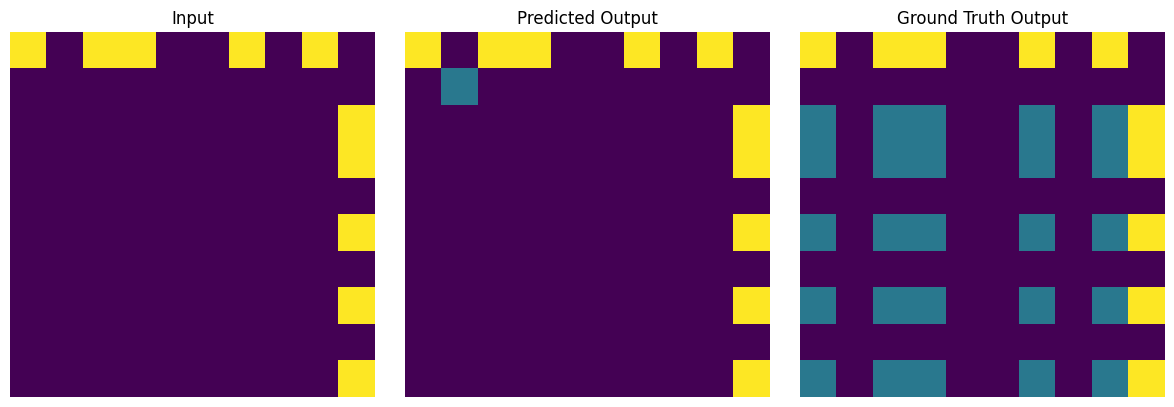

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Your test case
test_case = {
    "input": [
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]
    ],
    "output": [
        [5, 0, 5, 5, 0, 0, 5, 0, 5, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 2, 2, 0, 0, 2, 0, 2, 5]
    ]
}

# Apply your transform function
predicted_output = transform(test_case["input"])

# Plot the grids
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

titles = ["Input", "Predicted Output", "Ground Truth Output"]
grids = [test_case["input"], predicted_output, test_case["output"]]

for ax, grid, title in zip(axs, grids, titles):
    im = ax.imshow(grid, cmap="viridis", vmin=0, vmax=5)
    ax.set_title(title)
    ax.axis("off")

# fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()


In [32]:
stop

NameError: name 'stop' is not defined

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# !pip show transformers

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        # max_seq_length = 30000,
        load_in_4bit = False,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
from huggingface_hub import HfFolder, login

# Call this at the top of your script / notebook
if HfFolder.get_token() is None:   # no token cached or in $HF_TOKEN
    login()                        # interactive prompt

In [ ]:
# print(model)

In [ ]:
# run_name = "Qwen2.5-Coder-7B-Instruct-gemini_synth_50_random_split_1_training-20250723-113848"
print(f"Pushing to Trelis/{run_name}")

In [ ]:
model = model.merge_and_unload()
model.push_to_hub(f"Trelis/{run_name}")
tokenizer.push_to_hub(f"Trelis/{run_name}")

In [ ]:
# # Merge to 16bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if True: # Pushing to HF Hub
#     model.push_to_hub_merged(f"Trelis/{run_name}", tokenizer, save_method = "merged_16bit")

# # Merge to 4bit
# if False:
#     model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
# if False: # Pushing to HF Hub
#     model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# # Just LoRA adapters
# if False:
#     model.save_pretrained("model")
#     tokenizer.save_pretrained("model")
# if False: # Pushing to HF Hub
#     model.push_to_hub("hf/model", token = "")
#     tokenizer.push_to_hub("hf/model", token = "")


In [ ]:
# print(tokenizer.chat_template)

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False:
    model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False:
    model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
